# 머신 러닝 교과서 3판

# 17장 - 새로운 데이터 합성을 위한 생성적 적대 신경망 (2/2)

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch17/ch17_part2.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch17/ch17_part2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 합성곱 GAN과 와서스테인 GAN을 사용하여 합성 이미지의 품질 높이기
    - 전치 합성곱
    - 배치 정규화
    - 생성자와 판별자 구현하기
    - 두 분포 사이의 거리 측정하기
    - GAN에 EM 거리 사용하기
    - 그래디언트 페널티
    - WGAN-GP로 DCGAN 모델 훈련하기
    - 모드 붕괴
- 다른 GAN 애플리케이션
- 요약

In [1]:
from IPython.display import Image

# 합성곱 GAN과 와서스테인 GAN을 사용하여 합성 이미지의 품질 높이기

## 전치 합성곱

In [2]:
Image(url='https://git.io/JLjn7', width=700)

In [3]:
Image(url='https://git.io/JLjnb', width=700)

## 배치 정규화

In [4]:
Image(url='https://git.io/JLjnA', width=700)

## 생성자와 판별자 구현하기

In [5]:
Image(url='https://git.io/JLjnx', width=700)

In [6]:
Image(url='https://git.io/JLjnj', width=700)

 * **구글 코랩 설정**

In [7]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [8]:
import tensorflow as tf


print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU:0'

print(device_name)

2.14.0
GPU 여부: True
/device:GPU:0


In [9]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def make_dcgan_generator(
        z_size=20,
        output_size=(28, 28, 1),
        n_filters=128,
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor,
        output_size[1]//size_factor
    )

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),

        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size),
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),

        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())

    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5),
            strides=(1, 1), padding='same', use_bias=False,
            activation='tanh'))

    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64,
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5,
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5),
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))

    model.add(tf.keras.layers.Reshape((1,)))

    return model

In [11]:
gen_model = make_dcgan_generator()
gen_model.summary()

disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              125440    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         409600    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

## 두 분포 사이의 거리 측정하기

In [12]:
Image(url='https://git.io/JLjcf', width=700)

In [13]:
Image(url='https://git.io/JLjcJ', width=800)

## GAN에 EM 거리 사용하기

## 그래디언트 페널티

## WGAN-GP로 DCGAN 모델 훈련하기

In [14]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [15]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 생성
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization_7 (Bat  (None, 6272)              25088     
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 7, 7, 128)         409600    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 128)        

In [16]:
import time


## 옵티마이저:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):

        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)

            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## 생성자 손실을 계산합니다:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## 판별자 손실을 계산합니다:
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## 그래디언트 페널티:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1],
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)

            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))

            d_loss = d_loss + lambda_gp*grad_penalty

        ## 최적화: 그래디언트를 계산하고 적용합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))

        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(),
             d_loss_real.numpy(), d_loss_fake.numpy()))

    all_losses.append(epoch_losses)

    print('에포크 {:-3d} | 시간 {:.2f} min | 평균 손실 >>'
          ' 생성자/판별자 {:6.2f}/{:6.2f} [판별자-진짜: {:6.2f} 판별자-가짜: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60,
                  *list(np.mean(all_losses[-1], axis=0)))
    )

    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

에포크   1 | 시간 1.46 min | 평균 손실 >> 생성자/판별자 202.82/-334.89 [판별자-진짜: -206.73 판별자-가짜: -202.82]
에포크   2 | 시간 2.67 min | 평균 손실 >> 생성자/판별자 234.80/-207.13 [판별자-진짜: -158.48 판별자-가짜: -234.80]
에포크   3 | 시간 3.88 min | 평균 손실 >> 생성자/판별자 144.78/-43.22 [판별자-진짜: -58.92 판별자-가짜: -144.78]
에포크   4 | 시간 5.09 min | 평균 손실 >> 생성자/판별자  94.69/ 10.60 [판별자-진짜: -18.09 판별자-가짜: -94.69]
에포크   5 | 시간 6.30 min | 평균 손실 >> 생성자/판별자  59.15/-14.41 [판별자-진짜: -14.35 판별자-가짜: -59.15]
에포크   6 | 시간 7.52 min | 평균 손실 >> 생성자/판별자  43.81/  2.39 [판별자-진짜:   3.78 판별자-가짜: -43.81]
에포크   7 | 시간 8.74 min | 평균 손실 >> 생성자/판별자  57.37/-19.29 [판별자-진짜:  31.12 판별자-가짜: -57.37]
에포크   8 | 시간 9.97 min | 평균 손실 >> 생성자/판별자  59.18/-25.08 [판별자-진짜:  29.30 판별자-가짜: -59.18]
에포크   9 | 시간 11.18 min | 평균 손실 >> 생성자/판별자  72.61/-38.90 [판별자-진짜:  23.60 판별자-가짜: -72.61]
에포크  10 | 시간 12.40 min | 평균 손실 >> 생성자/판별자  56.56/-26.91 [판별자-진짜:  10.29 판별자-가짜: -56.56]
에포크  11 | 시간 13.62 min | 평균 손실 >> 생성자/판별자  79.68/-39.28 [판별자-진짜:  30.04 판별자-가짜: -79.68]
에포크  12 | 시간 14.83 min | 평균 손실 >>

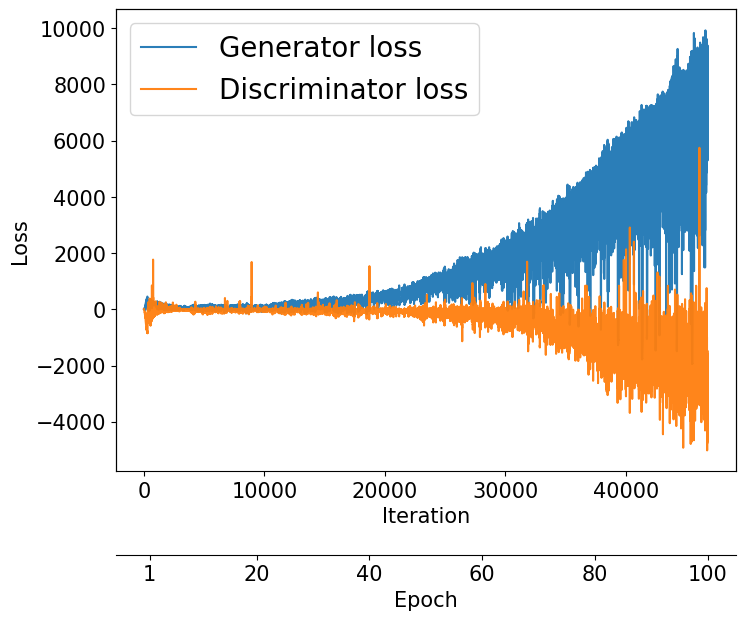

In [17]:
import itertools


fig = plt.figure(figsize=(8, 6))

## 손실 그래프
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

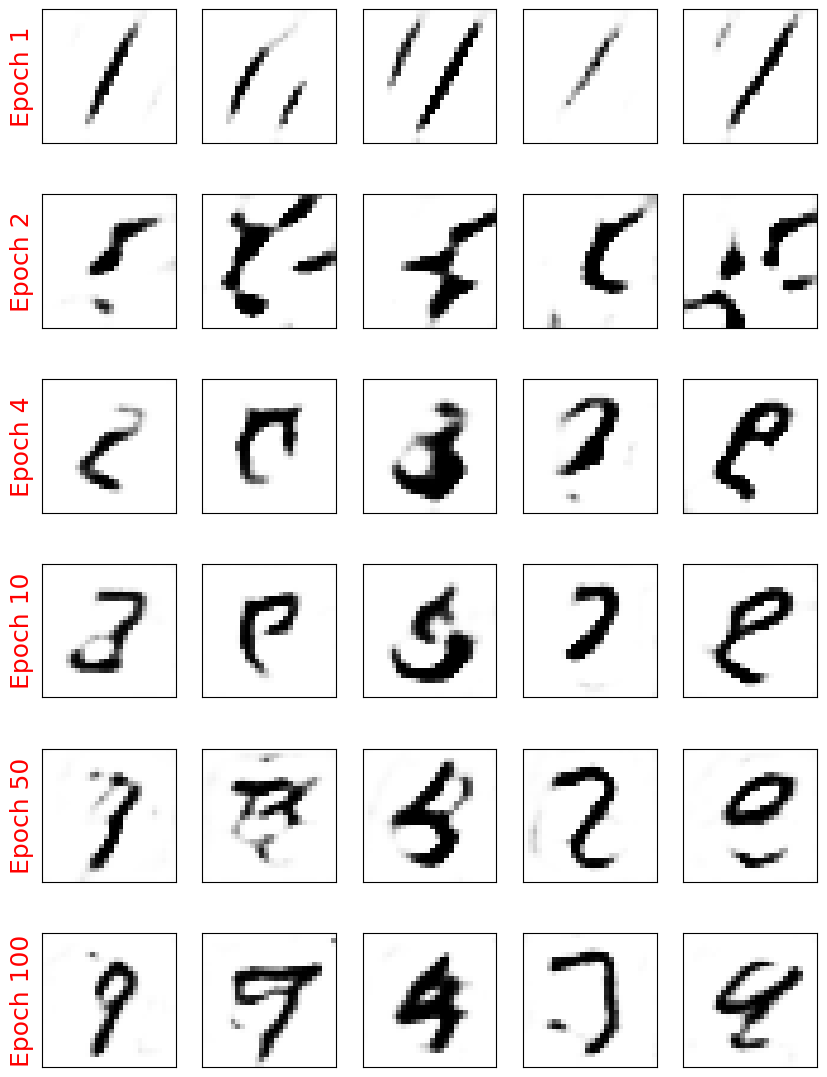

In [18]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

## 모드 붕괴

In [19]:
Image(url='https://git.io/JLjcT', width=600)